In [ ]:
# Visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv

# General
from time import time
import numpy as np
import pandas as pd

# sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

# File reading
from google.colab import drive
import pickle

# Data Loading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/Dataset/preprocessed_images.pkl', 'rb') as f:
    df_non_aug = pickle.load(f)

In [ ]:
df_non_aug

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",a
...,...,...
1195,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ư
1196,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ư
1197,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ư
1198,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ư


# PCA

In [ ]:
X_features = df_non_aug.drop('label', axis=1)

In [ ]:
X_features = np.concatenate(X_features.ravel()).reshape(X_features.shape[0], -1)

In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_features)

In [ ]:
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)

25.746323315799245


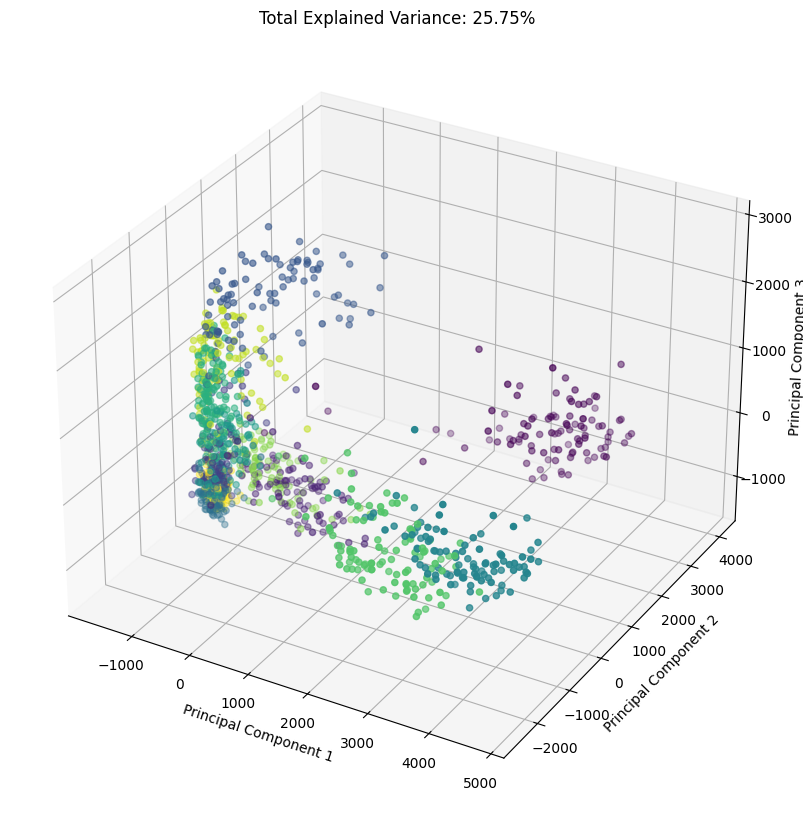

In [ ]:
plt.figure(figsize=(10, 20))

le = LabelEncoder()
numerical_labels = le.fit_transform(df_non_aug['label'])

ax = plt.axes(projection='3d')
ax.scatter(principalComponents[:, 0],
           principalComponents[:, 1],
           principalComponents[:, 2],
           c=numerical_labels)
plt.title(f'Total Explained Variance: {total_var:.2f}%')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [ ]:
pca = PCA(0.9)

In [ ]:
principalComponents = pca.fit_transform(X_features)

In [ ]:
pca.n_components_

312

# t-SNE

In [ ]:
y = df_non_aug['label']

In [ ]:
def plot_embedding(X, title, df):
    """
    Plots an embedding of data points, optionally with images overlaid.

    Parameters:
        X (array-like): The embedding coordinates of the data points.
        title (str): The title of the plot.
        df (DataFrame): The DataFrame containing the data, including the 'label' and 'image' columns.

    Returns:
        None
    """
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    global y

    # Convert labels to numerical if they are strings
    unique_labels = np.unique(y)
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    numerical_y = np.array([label_mapping[label] for label in y])

    for label in np.unique(numerical_y):
        ax.scatter(
            *X[numerical_y == label].T,  # Use numerical labels for indexing
            marker=f"${unique_labels[label]}$",  # Use original string labels for markers
            s=60,
            color=plt.cm.Dark2(label),
            alpha=0.425,
            zorder=2,
        )

    # Show images
    shown_images = np.array([[1.0, 1.0]])
    num_images_to_show = 30
    indices = np.random.choice(range(X.shape[0]), num_images_to_show, replace=False)

    for i in indices:
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)

        # Resize images to make them smaller
        image = df_non_aug['image'][i]
        image_resized = cv.resize(image, (20, 20))

        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(image_resized, cmap=plt.cm.gray_r), X[i] # Access df['image']
        )
        imagebox.set(zorder=2)
        ax.add_artist(imagebox)

    ax.figure.set_size_inches(10, 8)
    ax.set_title(title)
    ax.axis("off")

In [ ]:
# Reshape the image data into a 2D array where each row represents an image
# and each column represents a pixel. This is necessary for scikit-learn algorithms.

image_data_2d = X_features.reshape(X_features.shape[0], -1)

n_neighbors = 30

embeddings = {
    "t-SNE embedding": TSNE(
        n_components=2,
        max_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    )
}

projections = {}  # Create an empty dictionary to store projections
timing = {}  # Create an empty dictionary to store timing information

for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = image_data_2d.copy().astype(np.float64)  # Convert data to float64
        data.flat[:: data.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = image_data_2d  # Use the reshaped image data

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing t-SNE embedding...


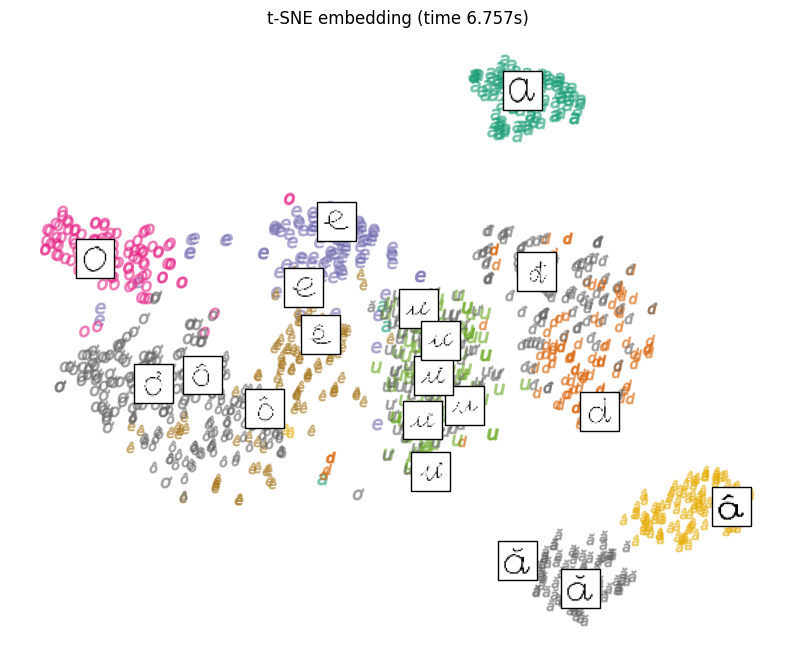

In [ ]:
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title, X_features)

plt.show()